<span style="color: green;">

# Introduction

In this laboratory we will get our hands dirty working with Large Language Models (e.g. GPT and BERT) to do various useful things. If you haven't already, it is highly recommended to:

- Read the [Attention is All you Need](https://arxiv.org/abs/1706.03762) paper, which is the basis for all transformer-based LLMs.
- Watch (and potentially _code along_) with this [Andrej Karpathy video](https://www.youtube.com/watch?v=kCc8FmEb1nY) which shows you how to build an autoregressive GPT model from the ground up.

# Exercise 1: Warming Up

In this first exercise you will train a _small_ autoregressive GPT model for character generation (the one used by Karpathy in his video) to generate text in the style of Dante Aligheri. Use [this file](https://archive.org/stream/ladivinacommedia00997gut/1ddcd09.txt), which contains the entire text of Dante's Inferno (**note**: you will have to delete some introductory text at the top of the file before training). Train the model for a few epochs, monitor the loss, and generate some text at the end of training. Qualitatively evaluate the results
</span>


Questo è il mio primo esercizio di NLP e ne approfitto per fare pratica con l'ecosistema di Hugging Face.
Il focus di questo esercizio non era quello di capire quale modello ha risultati migliori e quindi ho evitato di inserire Weigths and Bias perchè ritengo che un notebook è sufficiente per sperimentare velocemente con il testo.


## Installation


I worked with papavero.dinfo.unifi.it and I have installed the needed packages with the following commands:

```

conda install pytorch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 pytorch-cuda=11.8 -c pytorch -c nvidia
conda install -c conda-forge transformers
conda install conda-forge::matplotlib
pip install transformers[torch]
pip install scikit-learn
pip install evaluate

```


In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import os
import matplotlib.pyplot as plt
import numpy as np

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GenerationConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding

from transformers import TrainingArguments, Trainer

from datasets import load_dataset
import evaluate
import warnings

# serve per evitare gli warnings molto comuni quando lavori con hugging face
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

### Device


In [2]:
i = 0
if torch.cuda.is_available():
    device = torch.device("cuda:" + str(i))  # cuda:0 , cuda:1
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # yes, i have a MacBookPro with M1 Pro
else:
    device = torch.device("cpu")

print(f"device: {device}")
print(
    "GPU: " + torch.cuda.get_device_name(i)
    if device == torch.device("cuda:" + str(i))
    else ""
)

device: cuda:1
GPU: NVIDIA RTX A2000 12GB


### Hyperparameters


In [3]:
batch_size = 64  # how many indipendent sequences will be process in parallel ?
# what is the maximum context length for predictions ?
block_size = 256  # context_lenght
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
max_new_tokens = 5000

In [4]:
torch.manual_seed(1337)

### Pipeline seguita

- scarica il file
- elimina la parte iniziale (che contiene informazioni sulla licenza) per fare il training
- tokenizza il testo
- crea il modello
- fase di training (per poche epoche)
- guarda la loss
- genera testo e valuta qualitativamente i risultati


### Dataset


In [5]:
print("dataset\n")
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()
print(f"lenght of dataset in characters: {len(text)}\n")

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f'chars: {"".join(chars)}')
print(f"vocab_size: {vocab_size}")
# print(text[:400])

dataset

lenght of dataset in characters: 187078

chars: 
 !"',-.7:;<>?ABCDEFGHILMNOPQRSTUVXZ[]`abcdefghijlmnopqrstuvxz
vocab_size: 62


In [6]:
# create a mapping from character to integers
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

# encoder: take a string, output a list of integer
encode = lambda s: [stoi[c] for c in s]
# decoder: take a list of integer, output a string
decode = lambda l: "".join(itos[i] for i in l)

print(encode("Hi Vittorio"))
print(decode(encode("Hi Vittorio")))

[21, 47, 1, 33, 47, 57, 57, 52, 55, 47, 52]
Hi Vittorio


In [7]:
# let's now encode the entire text dataset and store it into a torch.Tensor
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])
# the 100 characters we looked at earlier will to the GPT look like this

torch.Size([187078]) torch.int64
tensor([23, 14,  1, 17, 22, 33, 22, 25, 14,  1, 16, 26, 24, 24, 18, 17, 22, 14,
         0,  0, 17, 22,  1, 17, 14, 25, 31, 18,  1, 14, 23, 22, 20, 21, 22, 18,
        29, 22,  0,  0,  0,  0,  0, 16, 14, 25, 31, 22, 16, 14,  1, 22,  9,  1,
        22, 25, 19, 18, 29, 25, 26,  0,  0,  0,  0,  0, 22, 51, 41, 47, 53, 47,
        57,  1, 16, 52, 50, 52, 43, 42, 47, 39,  1, 17, 39, 51, 57, 47, 56,  1,
        14, 49, 39, 45, 46, 43, 55, 47, 47,  5])


### Split


In [8]:
n = int(0.9 * len(data))  # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
print(f"Train data shape: {train_data.shape}")
print(train_data[:10])

Train data shape: torch.Size([168370])
tensor([23, 14,  1, 17, 22, 33, 22, 25, 14,  1])


In [9]:
print(f"Context lenght: {block_size}\n")
print("Chunk of data:")
train_data[: block_size + 1]

Context lenght: 256

Chunk of data:


tensor([23, 14,  1, 17, 22, 33, 22, 25, 14,  1, 16, 26, 24, 24, 18, 17, 22, 14,
         0,  0, 17, 22,  1, 17, 14, 25, 31, 18,  1, 14, 23, 22, 20, 21, 22, 18,
        29, 22,  0,  0,  0,  0,  0, 16, 14, 25, 31, 22, 16, 14,  1, 22,  9,  1,
        22, 25, 19, 18, 29, 25, 26,  0,  0,  0,  0,  0, 22, 51, 41, 47, 53, 47,
        57,  1, 16, 52, 50, 52, 43, 42, 47, 39,  1, 17, 39, 51, 57, 47, 56,  1,
        14, 49, 39, 45, 46, 43, 55, 47, 47,  5,  0, 19, 49, 52, 55, 43, 51, 57,
        47, 51, 47,  1, 51, 39, 57, 47, 52, 51, 43,  5,  1, 51, 52, 51,  1, 50,
        52, 55, 47, 40, 58, 56,  7,  0,  0,  0, 23, 39,  1, 17, 47, 59, 47, 51,
        39,  1, 16, 52, 50, 50, 43, 42, 47, 39,  0, 42, 47,  1, 17, 39, 51, 57,
        43,  1, 14, 49, 47, 45, 46, 47, 43, 55, 47,  0,  0,  0,  0,  0, 22, 25,
        19, 18, 29, 25, 26,  0,  0,  0,  0, 22, 51, 44, 43, 55, 51, 52,  9,  1,
        16, 39, 51, 57, 52,  1, 22,  0,  0,  0, 25, 43, 49,  1, 50, 43, 61, 61,
        52,  1, 42, 43, 49,  1, 41, 39, 

In [10]:
# how labeling works in NLP task
x = train_data[:block_size]
y = train_data[1 : block_size + 1]
print(f"Context lenght: {block_size}")
for t in range(block_size):
    context = x[: t + 1]
    target = y[t]
    print(f"when input is {context} the target is {target}")

    if t == 10:
        break

Context lenght: 256
when input is tensor([23]) the target is 14
when input is tensor([23, 14]) the target is 1
when input is tensor([23, 14,  1]) the target is 17
when input is tensor([23, 14,  1, 17]) the target is 22
when input is tensor([23, 14,  1, 17, 22]) the target is 33
when input is tensor([23, 14,  1, 17, 22, 33]) the target is 22
when input is tensor([23, 14,  1, 17, 22, 33, 22]) the target is 25
when input is tensor([23, 14,  1, 17, 22, 33, 22, 25]) the target is 14
when input is tensor([23, 14,  1, 17, 22, 33, 22, 25, 14]) the target is 1
when input is tensor([23, 14,  1, 17, 22, 33, 22, 25, 14,  1]) the target is 16
when input is tensor([23, 14,  1, 17, 22, 33, 22, 25, 14,  1, 16]) the target is 26


### Get batch of data


In [11]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == "train" else val_data
    ix = torch.randint(low=0, high=len(data) - block_size, size=(batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y


xb, yb = get_batch("train")

print("input: ")
print(f"\n{xb.shape}\n{xb}\n")
print("target: ")
print(f"\n{yb.shape}\n{yb}\n")

print("---")

# how batching works
for b in range(batch_size):  # 0 --> 4
    for t in range(block_size):  # 0 --> 8
        context = xb[b, : t + 1]
        target = yb[b, t]
        print(f"when input is {context} the target is {target}")
    break

input: 

torch.Size([64, 256])
tensor([[ 1, 49, 52,  ..., 58, 53, 52],
        [43, 56, 57,  ...,  1, 50, 47],
        [43, 51, 57,  ..., 52, 51,  1],
        ...,
        [31, 43, 45,  ..., 49, 47,  9],
        [24, 43, 42,  ..., 39, 49, 49],
        [45, 49, 47,  ...,  4, 49,  1]], device='cuda:1')

target: 

torch.Size([64, 256])
tensor([[49, 52,  1,  ..., 53, 52, 12],
        [56, 57, 43,  ..., 50, 47,  1],
        [51, 57, 43,  ..., 51,  1, 57],
        ...,
        [43, 45, 45,  ..., 47,  9,  1],
        [43, 42, 43,  ..., 49, 49, 43],
        [49, 47, 52,  ..., 49,  1, 42]], device='cuda:1')

---
when input is tensor([1], device='cuda:1') the target is 49
when input is tensor([ 1, 49], device='cuda:1') the target is 52
when input is tensor([ 1, 49, 52], device='cuda:1') the target is 1
when input is tensor([ 1, 49, 52,  1], device='cuda:1') the target is 56
when input is tensor([ 1, 49, 52,  1, 56], device='cuda:1') the target is 41
when input is tensor([ 1, 49, 52,  1, 56, 41],

### Trasformers Model


In [12]:
# thanks to Karpathy


class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=n_embd
        )
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        self.blocks = nn.Sequential(
            *[Block(n_embd, n_head=n_head) for _ in range(n_layer)]
        )
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(
            torch.arange(T, device=device)
        )  # (T, C )
        x = tok_emb + pos_emb  # (B, T, C)
        x = self.blocks(x)  # (B, T, C)
        x = self.ln_f(x)
        logits = self.lm_head(x)  # (B,T, vocab_size)
        # n.b: cross entropy vuole i logits con shape (B * T, C) e non (B, T, C)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    # function to generate from the model
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context

        for _ in range(max_new_tokens):
            # crop idx to the last block_size torkens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)  # logits.shape = (B * T, C)
            # focus only in the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append samples index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx


class Head(nn.Module):
    """one head of sel-attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)  # (B, T, C)
        q = self.query(x)  # (B, T, C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1)  # (B, T, C) @ (B, C, T) --> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B, T, C)
        out = wei @ v  # (B, T, T) @ (B,T,C) --> (B, T, C)
        return out


class MultiHeadAttention(nn.Module):
    """multiple heads of self-attention in parallell"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):
    """a simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """Trasformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [13]:
# create a model and optimizer
model = BigramLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters()) / 1e6, "M parameters")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

10.786622 M parameters


### Training Loop


In [14]:
os.makedirs("./text_generation_model/", exist_ok=True)

path_models = "./text_generation_model/model_text_generation.pth"

if not os.path.exists(path_models):  # se non esiste fai l'addestramento
    for iter in range(max_iters):
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0:
            losses = estimate_loss(model)
            print(
                f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
            )
        xb, yb = get_batch("train")
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        torch.save(model.state_dict(), path_models)
else:
    print(f"Model exist on path {path_models}")

step 0: train loss 4.3456, val loss 4.3465
step 500: train loss 1.7474, val loss 1.7952
step 1000: train loss 1.4303, val loss 1.5763
step 1500: train loss 1.2071, val loss 1.5241
step 2000: train loss 0.9782, val loss 1.5621
step 2500: train loss 0.7302, val loss 1.6635
step 3000: train loss 0.4952, val loss 1.8436
step 3500: train loss 0.3089, val loss 2.0559
step 4000: train loss 0.1930, val loss 2.2949
step 4500: train loss 0.1253, val loss 2.5463


### Text Generation


In [15]:
# model.load_state_dict(torch.load(path_models))
# # questa istruzione crea problemi se addestro su gpu su papavero e provo a caricare i pesi su mps o cpu,
# usa torhc.load specificando map_location il dispositivo mps o cpu
# torch.load(path_models, map_location=device)

model.load_state_dict(
    torch.load(path_models, map_location=device)
)  # carico il modello appena addestrato

# generates text
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=max_new_tokens)[0].tolist()))
# il testo generato a seguito dell'addestramento dovrebbe avere senso


  levato m'era del pontin duol s'aggirsiego
  quando i cavali al si volve le spalle,

<<O violenta lor da cio` sani a che:
  quando s'e` gia` mai di torto fuso,
  quanto 'l naso tutti ansicati onore:

che' l'altro e` 'l senso lor pondo scuro;
  per se l'altrui mostra quello 'Eta
  infino a lui baratti per lo luce>>.

Io li 'ntorno s'appresso lui talena,
  Mirra in su la steser cortei selvaggio
  tutta e sovra 'l suo campo stanno.

Uliscendo cadre mi percosse
  lui fuor d'aver che forze del face
  col loco ingheronqua la nebbia si tromba.

O vo' che sappi che, dirita` Tenesto
  non parelli e perduti, perche' 'l guide,
  sanza terra` scortare alte si cologne>>.

Quel dove sotto ruinar quell'abbica
  si racqua dal che Fiorenze, sembianza 'l tene,
  che tu, Giovean senti`, com'al punto
  tanto` d'i nel mio scoglio duri senti.

Francendi, che faccia come l'uom ch'ascolta,
  e l'imagine del sembiante stanca
  si suo s'altra fondo su`, che fu non segno
  si` croccia e ritrassi di questa coda

Il testo generato ha una grande somiglianza con lo stile di scrittura del noto poeta Dante. Si può notare come le frasi siano corte e risultano suddivise in gruppi di tre frasi (chiamate "terzine"). Ogni terzina ha le due ultime due frasi "indentate" a destra. La maggiorparte delle parole hanno un senso nella lingua italiana, altre invece contengono dei semplici errori di lettere all'interno.
Altra fattore da evidenziare è che il modello spesso riesce a capire quando siamo all'inizio di una conversazione e viene posto il carattere ":" prima del suo inizio.

Sicuramente con un addestramento con più epoche avremmo un risultato molto migliore ricco di altre caratteristiche dello stile di dante.


<span style="color: green;">

# Exercise 2: Working with Real LLMs

Our toy GPT can only take us so far. In this exercise we will see how to use the [Hugging Face](https://huggingface.co/) model and dataset ecosystem to access a _huge_ variety of pre-trained transformer models.

## Exercise 2.1: Installation and text tokenization

First things first, we need to install the [Hugging Face transformer library](https://huggingface.co/docs/transformers/index):

    conda install -c huggingface -c conda-forge transformers

The key classes that you will work with are `GPT2Tokenizer` to encode text into sub-word tokens, and the `GPT2LMHeadModel`. **Note** the `LMHead` part of the class name -- this is the version of the GPT2 architecture that has the text prediction heads attached to the final hidden layer representations (i.e. what we need to **generate** text).

Instantiate the `GPT2Tokenizer` and experiment with encoding text into integer tokens. Compare the length of input with the encoded sequence length.

**Tip**: Pass the `return_tensors='pt'` argument to the togenizer to get Pytorch tensors as output (instead of lists).
</span>


### Pipeline svolta

- installa HF transformers
- è stato necessario eseguire anche --> conda install -c conda-forge huggingface_hub
- encode text into sub-word tokens with GPT2Tokenizer
- istanzia GPT2Tokenizer e converti il testo in token interi
- confronta la lunghezza dell'input (testo) con la lunghezza della sequenza codificata (lunghezza della sequenza di interi)


### Tokenizer


In [16]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# stampa gli attributi e i metodi che posso invocare con l'oggetto tokenizer
# print(*dir(tokenizer), sep="\n")
# print(tokenizer.get_vocab) # important params settings

print(f"Vocab size: {tokenizer.vocab_size}")
print(f"Model max length: {tokenizer.model_max_length}\n")

print(tokenizer.encode("Hi Vittorio"))  # dict with keys: input_ids, attention_mask
print(tokenizer.decode(tokenizer.encode("Hi Vittorio")))

Vocab size: 50257
Model max length: 1024

[17250, 569, 715, 40974]
Hi Vittorio


Funzione per vedere come viene codificata una data frase. Nella stampa non viene stampata la codifica se risulta essere molto ingombrante nell'output


In [17]:
def view_encoded_text(text, huge=False):
    encoded_text = tokenizer(text, return_tensors="pt")["input_ids"]
    contents = f"{text} --> {encoded_text}" if huge == False else ""
    print(
        f"° length text (in characters): {len(text)} - length encoded text: {encoded_text.shape[1]}\t {contents}"
    )

In [18]:
print("Esempi:\n")
view_encoded_text("Good Morning!")
view_encoded_text(" Good Morning!")
view_encoded_text("  Good Morning!")
view_encoded_text("   Good Morning!")
view_encoded_text("Good Morning!   ")
view_encoded_text("Good Morning!  ")
view_encoded_text("Good Morning! ")
view_encoded_text("Good Morning!")

Esempi:

° length text (in characters): 13 - length encoded text: 3	 Good Morning! --> tensor([[10248, 14410,     0]])
° length text (in characters): 14 - length encoded text: 3	  Good Morning! --> tensor([[ 4599, 14410,     0]])
° length text (in characters): 15 - length encoded text: 4	   Good Morning! --> tensor([[  220,  4599, 14410,     0]])
° length text (in characters): 16 - length encoded text: 5	    Good Morning! --> tensor([[  220,   220,  4599, 14410,     0]])
° length text (in characters): 16 - length encoded text: 6	 Good Morning!    --> tensor([[10248, 14410,     0,   220,   220,   220]])
° length text (in characters): 15 - length encoded text: 5	 Good Morning!   --> tensor([[10248, 14410,     0,   220,   220]])
° length text (in characters): 14 - length encoded text: 4	 Good Morning!  --> tensor([[10248, 14410,     0,   220]])
° length text (in characters): 13 - length encoded text: 3	 Good Morning! --> tensor([[10248, 14410,     0]])


Da notare che la lunghezza del testo codificato tiene conto del numero di parole e della punteggiatura (carattere spazio incluso).
Per evitare di scrivere un programma che conti il numero di parole e il numero di caratteri della punteggiatura contiamo i caratteri della testo come avevamo fatto nel precedente esercizio.

Si può notare che all'aumentare/diminuire della lunghezza del testo aumenta/diminuisce la lunghezza della sequenza di interi. Però fra le due lenght non c'è una corrispondenza biunivoca (per esempio ad un testo di 13 caratteri potrebbero corrispondere una codifica con 3 o 4 interi come si può vedere negli esempi sopra).
Si può notare inoltre che l'aggiunta di tanti spazi fa aumentare la lunghezza della sequenza di interi. Questo potrebbe essere uno svantaggio in certi casi. In genere l'aggiunta di più di uno spazio nella scrittura con tastiera qwerty è un'errore di battitura che però un modello di linguaggio codifica come input di testo grezzo e potrebbe creare delle relazioni tra parole successive.

Proviamo con esempi di testo più lunghi.


In [19]:
view_encoded_text(
    "My name is Vittorio Casula. I'm 26 years old. I graduated in Computer Engineering in 2021 at University of Florence.",
    huge=True,
)
view_encoded_text(
    "My best purchase of the last 2 years is my Macbook Pro with M1 Pro Processor. Thanks to it, I'm able to run fast my Machine Learning Script on my laptop.",
    huge=True,
)
view_encoded_text(
    "However, I believe that the optimal setup for working in the Machine Learning field should involve two devices: the first being a laptop (not necessarily a MacBook) with a large-capacity battery, and the second being a server (connected via SSH) on which you can run your scripts without utilizing the resources of the laptop.",
    huge=True,
)

° length text (in characters): 116 - length encoded text: 27	 
° length text (in characters): 153 - length encoded text: 37	 
° length text (in characters): 326 - length encoded text: 64	 


### Compare between text length and encoded text length


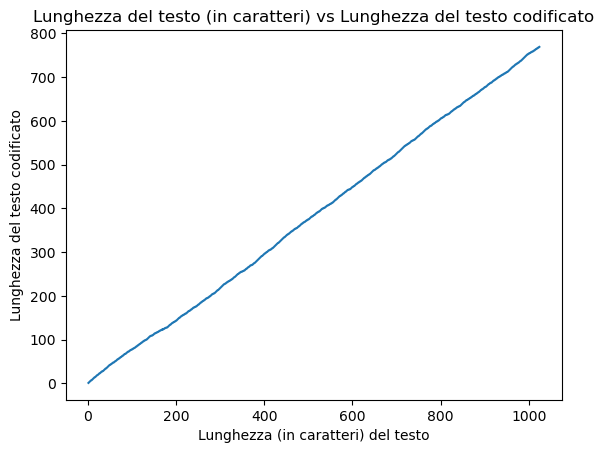

In [20]:
# proviamo a fare una stringa dinamica che diventa sempre più lunga

dynamic_str = ""
len_max = 1024
chars = f"ABCDEFGHILMNOPQRSTUVXZabcdefghijlmnopqrstuvxz0123456789"
indices = torch.randint(low=0, high=len(chars), size=(len_max,)).tolist()

lengths_text = []
lengths_encoded_text = []
for i in range(len(indices)):
    dynamic_str += chars[indices[i]]
    lengths_text.append(len(dynamic_str))
    lengths_encoded_text.append(
        tokenizer(dynamic_str, return_tensors="pt")["input_ids"].shape[1]
    )

plt.title("Lunghezza del testo (in caratteri) vs Lunghezza del testo codificato")
plt.xlabel("Lunghezza (in caratteri) del testo")
plt.ylabel("Lunghezza del testo codificato")

plt.plot(lengths_text, lengths_encoded_text)

Quando la lunghezza dei caratteri è pari a 1000 la lunghezza del testo codificato è pari a 800. Questo gap diventerà tanto più grande al crescere del testo.


<span style="color: green;">

## Exercise 2.2: Generating Text

There are a lot of ways we can, given a _prompt_ in input, sample text from a GPT2 model. Instantiate a pre-trained `GPT2LMHeadModel` and use the [`generate()`](https://huggingface.co/docs/transformers/v4.27.2/en/main_classes/text_generation#transformers.GenerationMixin.generate) method to generate text from a prompt.

**Note**: The default inference mode for GPT2 is _greedy_ which might not results in satisfying generated text. Look at the `do_sample` and `temperature` parameters.
</span>


In [21]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

input_text = "My name is Vittorio. I'm AI student at University of Florence."

inputs = tokenizer(input_text, return_tensors="pt")
# print(*inputs)  # get the keys of returned dict

### Generation


In [22]:
# outputs = model.generate(**inputs) # warning: Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
outputs = model.generate(**inputs, pad_token_id=tokenizer.eos_token_id)
print(f"Generated text: \n{tokenizer.decode(outputs[0])}")
# if you want decode multiple interger sequence you should use batch_decode()

Generated text: 
My name is Vittorio. I'm AI student at University of Florence. I'm a member


In [23]:
# interesting warning:Using the model-agnostic default `max_length` (=20) to control thegeneration length.
# We recommend setting `max_new_tokens` to control the maximum length of the generation.

outputs = model.generate(
    **inputs, pad_token_id=tokenizer.eos_token_id, max_new_tokens=100
)
# print(outputs)
print("Generated text: \n")
print(tokenizer.decode(outputs[0]))

Generated text: 

My name is Vittorio. I'm AI student at University of Florence. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team.


Come vediamo il testo generato contiene il testo iniziamente codificato e una frase generata che si ripete fino a raggiungere il numero massimo di token specificato. Non ha molto senso questo testo generato. Proviamo a sperimentare con i parametri "do_sample" e "temperature".


In [24]:
# check "do_sample" and "temperature" parameters
# link: https://huggingface.co/docs/transformers/generation_strategies

In [25]:
print(model.generation_config)
# Printing out the model.generation_config reveals only the values that are different from the default generation configuration,
# and does not list any of the default values.

# The default generation configuration limits the size of the output combined with the input prompt to a maximum of 20 tokens
# to avoid running into resource limitations. The default decoding strategy is greedy search, which is the simplest decoding
# strategy that picks a token with the highest probability as the next token. For many tasks and small output sizes this works well.
# However, when used to generate longer outputs, greedy search can start producing highly repetitive results.

GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "transformers_version": "4.31.0"
}



### Customize Text Generation


do_sample: if set to True, this parameter enables decoding strategies such as multinomial sampling, beam-search multinomial sampling,
Top-K sampling and Top-p sampling. All these strategies select the next token from the probability distribution over the entire vocabulary
with various strategy-specific adjustments.


In [26]:
outputs = model.generate(
    **inputs, pad_token_id=tokenizer.eos_token_id, max_new_tokens=100, do_sample=True
)
# print(outputs)
print("Generated text: \n")
print(tokenizer.decode(outputs[0]))

Generated text: 

My name is Vittorio. I'm AI student at University of Florence. My name is Vittorio and I am a freelance writer from Italy. My work is now available under license from the author and I hope to see you there!"

"Hello, Vittorio. My name is Vittorio and I am a freelance writer from Italy. My work is now available under license from the author and I hope to see you there!"

"Why haven't you come to the United States?", "Hi, Vittorio. My name is Vitt


In [27]:
generation_config = GenerationConfig(
    max_new_tokens=50,
    do_sample=True,
    top_k=50,
    eos_token_id=model.config.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
)

outputs = model.generate(**inputs, generation_config=generation_config)
# print(outputs)
print("Generated text: \n")
print(tokenizer.decode(outputs[0]))

Generated text: 

My name is Vittorio. I'm AI student at University of Florence. Thanks so much to me for sharing my first day teaching :)

[…]<|endoftext|>


Assisted decoding is a modification of the decoding strategies above that uses an assistant model with the same tokenizer (ideally a much smaller model) to greedily generate a few candidate tokens. The main model then validates the candidate tokens in a single forward pass, which speeds up the decoding process. Currently, only greedy search and sampling are supported with assisted decoding, and doesn’t support batched inputs. To learn more about assisted decoding, check this blog post.


When using assisted decoding with sampling methods, you can use the temperature argument to control the randomness just like in multinomial sampling. However, in assisted decoding, reducing the temperature will help improving latency.


In [28]:
temperature = [0.2, 0.4, 0.6, 0.8, 1]
for temp in temperature:
    outputs = model.generate(
        **inputs, generation_config=generation_config, do_sample=True, temperature=temp
    )
    print(f"\n° Generated text (temperature = {temp}):")
    print(f"{tokenizer.decode(outputs[0])}")


° Generated text (temperature = 0.2):
My name is Vittorio. I'm AI student at University of Florence. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team. I'm a member of the Italian National Team.

° Generated text (temperature = 0.4):
My name is Vittorio. I'm AI student at University of Florence. I'm the head of a team that's working on a new version of the game called 'The World of Artificial Intelligence'. I'm also the creator of the game. I'm very excited to be working with you.

Vittorio:

° Generated text (temperature = 0.6):
My name is Vittorio. I'm AI student at University of Florence. I am a former world champion in the chess world and I am currently playing in the world championship. I am the first of my kind to compete in the world championship and I'm very happy."<|endoftext|>

° Generated text (temperature = 0.8):
My name is Vittorio. I'm AI student at Un

Testo generato molto vario al crescere del parametro temperature. Per piccoli valori di temperature si ha il fenomeno della ripetizione del testo. Per valori intermedi si ha la ripetizione del testo con qualche piccola variazione (ad esempio: "I'm a teacher of music." e "I'm teacher of literature").


<span style="color: green;">

# Exercise 3: Reusing Pre-trained LLMs (choose one)

Choose **one** of the following exercises (well, _at least_ one). In each of these you are asked to adapt a pre-trained LLM (`GPT2Model` or `DistillBERT` are two good choices) to a new Natural Language Understanding task. A few comments:

- Since GPT2 is a _autoregressive_ model, there is no latent space aggregation at the last transformer layer (you get the same number of tokens out that you give in input). To use a pre-trained model for a classification or retrieval task, you should aggregate these tokens somehow (or opportunistically select _one_ to use).

- BERT models (including DistillBERT) have a special [CLS] token prepended to each latent representation in output from a self-attention block. You can directly use this as a representation for classification (or retrieval).

- The first _two_ exercises below can probably be done _without_ any fine-tuning -- that is, just training a shallow MLP to classify or represent with the appropriate loss function.

# Exercise 3.1: Training a Text Classifier (easy) <span style="color: red;">(DONE)</span>

Peruse the [text classification datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:text-classification&sort=downloads). Choose a _moderately_ sized dataset and use a LLM to train a classifier to solve the problem.

**Note**: A good first baseline for this problem is certainly to use an LLM _exclusively_ as a feature extractor and then train a shallow model.

# Exercise 3.2: Training a Question Answering Model (harder)

Peruse the [multiple choice question answering datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:multiple-choice&sort=downloads). Chose a _moderately_ sized one and train a model to answer contextualized multiple-choice questions. You _might_ be able to avoid fine-tuning by training a simple model to _rank_ the multiple choices (see margin ranking loss in Pytorch).

# Exercise 3.3: Training a Retrieval Model (hardest)

The Hugging Face dataset repository contains a large number of ["text retrieval" problems](https://huggingface.co/datasets?task_categories=task_categories:text-retrieval&p=1&sort=downloads). These tasks generally require that the model measure _similarity_ between text in some metric space -- naively, just a cosine similarity between [CLS] tokens can get you pretty far. Find an interesting retrieval problem and train a model (starting from a pre-trained LLM of course) to solve it.

**Tip**: Sometimes identifying the _retrieval_ problems in these datasets can be half the challenge. [This dataset](https://huggingface.co/datasets/BeIR/scifact) might be a good starting point.
</span>


### Model: GPT2


In [29]:
name_model_pretrained = "gpt2"
os.makedirs("./text_classification_model/", exist_ok=True)

Dataset scelto: tweet_eval (link: https://huggingface.co/datasets/tweet_eval)

TweetEval consists of seven heterogenous tasks in Twitter, all framed as multi-class tweet classification. The tasks include - irony, hate, offensive, stance, emoji, emotion, and sentiment. All tasks have been unified into the same benchmark, with each dataset presented in the same format and with fixed training, validation and test splits.
The text in the dataset is in English, as spoken by Twitter users.

# selected task: emoji


In [30]:
dataset = load_dataset("tweet_eval", "emoji")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})


In [31]:
# some example
dataset["train"][:5]

{'text': ['Sunday afternoon walking through Venice in the sun with @user ️ ️ ️ @ Abbot Kinney, Venice',
  "Time for some BBQ and whiskey libations. Chomp, belch, chomp! (@ Lucille's Smokehouse Bar-B-Que)",
  'Love love love all these people ️ ️ ️ #friends #bff #celebrate #blessed #sundayfunday @ San…',
  '️ ️ ️ ️ @ Toys"R"Us',
  'Man these are the funniest kids ever!! That face! #HappyBirthdayBubb @ FLIPnOUT Xtreme'],
 'label': [12, 19, 0, 0, 2]}

### Data Fields

For emoji config:

- text: a string feature containing the tweet
- label: an int classification label with the following mapping


![labels](./img/labels.png)


In [32]:
id2label = {
    0: "Red Heart",
    1: "Smiling Face with Heart-Eyes",
    2: "Face with Tears of Joy",
    3: "Two Hearts",
    4: "Fire",
    5: "Smiling Face with Similing Eyes",
    6: "Similing Face with Sunglasses",
    7: "Sparkles",
    8: "Blue Heart",
    9: "Face Blowing a Kiss",
    10: "Camera",
    11: "Flag United States",
    12: "Sun",
    13: "Purple Heart",
    14: "Winking Face",
    15: "Hundred Points",
    16: "Beaming Face with Smiling Eyes",
    17: "Christmas Tree",
    18: "Camera with Flash",
    19: "Winking Face with Tongue",
}

label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)

### Tokenizer


In [33]:
tokenizer = AutoTokenizer.from_pretrained(name_model_pretrained)
tokenizer.pad_token = tokenizer.eos_token
print(tokenizer)

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True)


Si può notare che a partire dal modello preaddestrato con la classe AutoTokenizer si può ricavare il Tokenizer usato per l'addestramento di tale modello.


In [34]:
# funzione per calcolare l'accuracy (viene usata la funzione di sk-learn)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


# funzione per effettuare la tokenizzazione di tutto il dataset (di tutti gli split)
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)


# tokenizzazione del dataset
tokenized_tweet_eval = dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
accuracy = evaluate.load("accuracy")

Con le istruzioni seguenti settiamo il mostro modello pre-addestrato GPT2
Viene impostato l'ID del token di padding (pad_token_id) del modello uguale all'ID del token di fine frase (eos_token_id) del modello.

Il token di padding viene utilizzato nelle operazioni di elaborazione del linguaggio naturale, in particolare durante il padding delle sequenze di testo di lunghezza variabile in modo che abbiano tutte la stessa lunghezza.


In [35]:
model = AutoModelForSequenceClassification.from_pretrained(
    name_model_pretrained, num_labels=num_labels, id2label=id2label, label2id=label2id
)
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training


In [36]:
training_args = TrainingArguments(
    output_dir="./text_classification_model/emoji/",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    # lr_scheduler_type="reduce_lr_on_plateau",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    optim="adamw_torch"
    # no_cuda=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_tweet_eval["train"],
    eval_dataset=tokenized_tweet_eval["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [37]:
trainer.train()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.115200,2.580721,0.236400
2,1.886200,2.424846,0.265200
3,1.777500,2.394025,0.276600
4,1.701400,2.404632,0.277000
5,1.650600,2.405973,0.279800


TrainOutput(global_step=7035, training_loss=1.8525871575090507, metrics={'train_runtime': 6328.7697, 'train_samples_per_second': 35.552, 'train_steps_per_second': 1.112, 'total_flos': 1.345377152249856e+16, 'train_loss': 1.8525871575090507, 'epoch': 5.0})

Questo addestramento è stato fatto anche per un numero di epoche ben più grande (30 epoche) ma il risultato in termini di validation accuracy non è cambiato molto (a partire dalla 3°/4° epoca si mantiene costante). Ho deciso quindi di effettuare tutti i training fino a 5 epoche.

Come vediamo sia la training loss sia la validation loss tendono a scendere. La validation loss però da una certa epoca in poi inizierà a salire (ma non troppo) generando overfitting. Questa situazione è stata vista solo per il task di emoji classification.

Come vediamo la accuracy sul validation set è piuttosto bassa (0.28) e questo si è verificato solo per il task di emoji classification. Per altri task si ha delle performance molto più alte.


### Evalution on Test set


In [38]:
path_models = "./text_classification_model/emoji/best_model/"
trainer.save_model(path_models)
model = AutoModelForSequenceClassification.from_pretrained(path_models)
trainer.evaluate(eval_dataset=tokenized_tweet_eval["test"])  # on test set

{'eval_loss': 1.7835158109664917,
 'eval_accuracy': 0.45326,
 'eval_runtime': 381.3932,
 'eval_samples_per_second': 131.098,
 'eval_steps_per_second': 4.098,
 'epoch': 5.0}

## Inference


In [39]:
def inference(sequence_to_classify):
    model = AutoModelForSequenceClassification.from_pretrained(path_models).to(device)
    tokenizer = AutoTokenizer.from_pretrained(name_model_pretrained)
    encoded_sequence = tokenizer(sequence_to_classify, return_tensors="pt")
    encoded_sequence = encoded_sequence.to(device)
    logits = model(**encoded_sequence).logits
    predicted_class = logits.argmax().item()
    print(
        f"{sequence_to_classify} --> Classe predetta: {predicted_class} ({id2label[predicted_class]}) - score = {torch.softmax(logits, dim=1).squeeze(0)[predicted_class]:.4f}"
    )

In [40]:
inference("i love you")
inference("i missed you")
inference("Happy new Year!")
inference("Merry Christmas!")

i love you --> Classe predetta: 3 (Two Hearts) - score = 0.3351
i missed you --> Classe predetta: 3 (Two Hearts) - score = 0.3388
Happy new Year! --> Classe predetta: 5 (Smiling Face with Similing Eyes) - score = 0.2897
Merry Christmas! --> Classe predetta: 17 (Christmas Tree) - score = 0.7714


In [41]:
inference("Do you take a photo together?")

Do you take a photo together? --> Classe predetta: 1 (Smiling Face with Heart-Eyes) - score = 0.2596


In [42]:
inference("I'd rather burn myself")
inference("fuck you")

I'd rather burn myself --> Classe predetta: 2 (Face with Tears of Joy) - score = 0.3421
fuck you --> Classe predetta: 2 (Face with Tears of Joy) - score = 0.1922


In [43]:
inference("make america great again")
inference("max points")
inference("highest quality")
inference("best quality")

make america great again --> Classe predetta: 11 (Flag United States) - score = 0.4796
max points --> Classe predetta: 2 (Face with Tears of Joy) - score = 0.1623
highest quality --> Classe predetta: 1 (Smiling Face with Heart-Eyes) - score = 0.2360
best quality --> Classe predetta: 1 (Smiling Face with Heart-Eyes) - score = 0.2050


# selected task: emotion

Task: classificare se un certo tweet appartiene ad una delle seguenti classi:

- 0: anger
- 1: joy
- 2: optimism
- 3: sadness


In [44]:
dataset = load_dataset("tweet_eval", "emotion")

id2label = {0: "anger", 1: "joy", 2: "optimism", 3: "sadness"}
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})


Tokenizer &Training


In [45]:
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)
tokenizer = AutoTokenizer.from_pretrained(name_model_pretrained)
tokenizer.pad_token = tokenizer.eos_token

os.environ[
    "CUDA_VISIBLE_DEVICES"
] = "1"  # la gpu:0 di papavero era occupata, con questa istruzione faccio in modo di vedere solo la gpu:1

tokenized_tweet_eval = dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
accuracy = evaluate.load("accuracy")

model = AutoModelForSequenceClassification.from_pretrained(
    name_model_pretrained, num_labels=num_labels, id2label=id2label, label2id=label2id
)
model.config.pad_token_id = model.config.eos_token_id

training_args = TrainingArguments(
    output_dir="./text_classification_model/emotion/",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    # lr_scheduler_type="reduce_lr_on_plateau",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    optim="adamw_torch"
    # no_cuda=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_tweet_eval["train"],
    eval_dataset=tokenized_tweet_eval["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.874171,0.663102
2,No log,0.787727,0.708556
3,0.895500,0.759338,0.740642
4,0.895500,0.705613,0.754011
5,0.431400,0.725681,0.748663


TrainOutput(global_step=1020, training_loss=0.6574719746907552, metrics={'train_runtime': 729.2521, 'train_samples_per_second': 22.331, 'train_steps_per_second': 1.399, 'total_flos': 1320700813028352.0, 'train_loss': 0.6574719746907552, 'epoch': 5.0})

Ottima performance in questo caso. Le due loss hanno la tendenza a decrescere.


Evaluation


In [46]:
path_models = "./text_classification_model/emotion/best_model/"
trainer.save_model(path_models)
model = AutoModelForSequenceClassification.from_pretrained(path_models)
trainer.evaluate(eval_dataset=tokenized_tweet_eval["test"])  # on test set

{'eval_loss': 0.5950714945793152,
 'eval_accuracy': 0.8114004222378607,
 'eval_runtime': 19.4247,
 'eval_samples_per_second': 73.154,
 'eval_steps_per_second': 4.582,
 'epoch': 5.0}

Inference


In [47]:
inference("Don't give up!")
inference("i missed you")
inference("Fuck you")
inference("i'm sad")

Don't give up! --> Classe predetta: 2 (optimism) - score = 0.7774
i missed you --> Classe predetta: 3 (sadness) - score = 0.9350
Fuck you --> Classe predetta: 0 (anger) - score = 0.9681
i'm sad --> Classe predetta: 3 (sadness) - score = 0.9910


# selected task: offensive

task: classificare un tweet come offensivo o meno


In [48]:
dataset = load_dataset("tweet_eval", "offensive")
print(dataset)
id2label = {0: "non offensive", 1: "offensive"}

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11916
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 860
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1324
    })
})


Tokenizer & Training


In [49]:
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)
tokenizer = AutoTokenizer.from_pretrained(name_model_pretrained)
tokenizer.pad_token = tokenizer.eos_token

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

tokenized_tweet_eval = dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
accuracy = evaluate.load("accuracy")

model = AutoModelForSequenceClassification.from_pretrained(
    name_model_pretrained, num_labels=num_labels, id2label=id2label, label2id=label2id
)
model.config.pad_token_id = model.config.eos_token_id

training_args = TrainingArguments(
    output_dir="./text_classification_model/offensive/",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    # lr_scheduler_type="reduce_lr_on_plateau",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    optim="adamw_torch"
    # no_cuda=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_tweet_eval["train"],
    eval_dataset=tokenized_tweet_eval["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

Map:   0%|          | 0/1324 [00:00<?, ? examples/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.600400,0.440464,0.793807
2,0.446600,0.448583,0.797583
3,0.354300,0.455695,0.799849
4,0.337700,0.474835,0.802115
5,0.278900,0.507768,0.797583


TrainOutput(global_step=3725, training_loss=0.38435423166159816, metrics={'train_runtime': 3140.5357, 'train_samples_per_second': 18.971, 'train_steps_per_second': 1.186, 'total_flos': 6116899772694528.0, 'train_loss': 0.38435423166159816, 'epoch': 5.0})

In questo caso si sta manifestando il fenomeno dell'overfitting ma la performance è ottima sul validation set.


Evaluation


In [50]:
path_models = "./text_classification_model/offensive/best_model/"
trainer.save_model(path_models)
model = AutoModelForSequenceClassification.from_pretrained(path_models)
trainer.evaluate(eval_dataset=tokenized_tweet_eval["test"])  # on test set

{'eval_loss': 0.37114962935447693,
 'eval_accuracy': 0.8395348837209302,
 'eval_runtime': 14.5045,
 'eval_samples_per_second': 59.292,
 'eval_steps_per_second': 3.723,
 'epoch': 5.0}

Inference


In [51]:
inference("You're so stupid.")
inference("I appreciate your hard work.")
inference("You are a wonderful person.")
inference("You look ugly today.")
inference("I can't believe you did that, you're amazing!")
inference("You're a worthless human being.")
inference("You're such a kind soul.")
inference("You're a terrible friend.")
inference("You're an inspiration to others.")
inference("You're a waste of space.")
inference("you are a disgrace")

You're so stupid. --> Classe predetta: 1 (offensive) - score = 0.9587
I appreciate your hard work. --> Classe predetta: 0 (non offensive) - score = 0.9878
You are a wonderful person. --> Classe predetta: 0 (non offensive) - score = 0.9909
You look ugly today. --> Classe predetta: 1 (offensive) - score = 0.8865
I can't believe you did that, you're amazing! --> Classe predetta: 0 (non offensive) - score = 0.9836
You're a worthless human being. --> Classe predetta: 1 (offensive) - score = 0.9646
You're such a kind soul. --> Classe predetta: 0 (non offensive) - score = 0.9132
You're a terrible friend. --> Classe predetta: 1 (offensive) - score = 0.8463
You're an inspiration to others. --> Classe predetta: 0 (non offensive) - score = 0.9813
You're a waste of space. --> Classe predetta: 1 (offensive) - score = 0.7860
you are a disgrace --> Classe predetta: 1 (offensive) - score = 0.7318
